In [1]:
import pandas as pd
from datetime import datetime, date
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from pandas_profiling import ProfileReport

pd.options.display.max_rows = 40
pd.options.display.max_columns = None

In [2]:
def generate_installment_dates(row):
    periodicity = row.Periodicity
    deltas_periodicity = {
        "Biweekly": relativedelta(weeks=2),
        "Weekly": relativedelta(weeks=2),
        "Monthly": relativedelta(months=1)
    }
    if periodicity not in deltas_periodicity:
        return []
    
    delta_periodicity = deltas_periodicity[periodicity]
    
    orig_date = row.OriginationDate
    terms = row.Term
    
    dates = []
    curr = orig_date
    for _ in range(terms):
        curr += delta_periodicity
        dates.append(curr.date())
    
    return dates

# Load and analyze data

## Agency product name
>  Información sobre agencia que agrupa créditos, el tipo de crédito (PDL o BGL, payday loans o business growth loans, respectivamente).

```
AgencyId (Entero): ID de agencia (dependencia) de Hopp a la que pertenece el crédito.

ProductName (Categórica): Tipo de producto (PDL, BGL).

Country (Categórica): País de la operación.
```

In [3]:
df_agency = pd.read_csv("loan_agency_product_name.csv")
profile = ProfileReport(df_agency, title="Agency product name", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Funding Origination

> Información sobre a qué agencia pertenece cada crédito y la fecha de creación de cada crédito.

```
- LoanId (Entero): ID único del crédito.

- AgencyId (Entero): ID de agencia (dependencia) de Hopp a la que pertenece el crédito.

- FundingID (Entero): ID de la entidad financiadora.

- OriginationDate (Datetime): Fecha de originación del crédito.

- InstallmentAmount (Decimal): Valor del préstamo (valor de la cuota correspondiente = InstallmentAmount/Term).

- Periodicity (Categórica): Periodicidad del crédito.

- LoanOperationalStatus (Categórica): Estado operacional del crédito al fin del período (diciembre 2020).

- VAT (Entero): Porcentaje asignado al IVA.

- Term (Entero): Cantidad de plazos del crédito.
```

In [4]:
df_orig = pd.read_csv("loan_funding_origination_info.csv", parse_dates=["OriginationDate"])
df_orig.rename(inplace=True, columns={"InstallmentAmount":"LoanAmount"})
df_orig["InstallmentAmount"] = df_orig.LoanAmount / df_orig.Term

profile = ProfileReport(df_orig, title="Funding Origination", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/nox/repos/venv/lib64/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

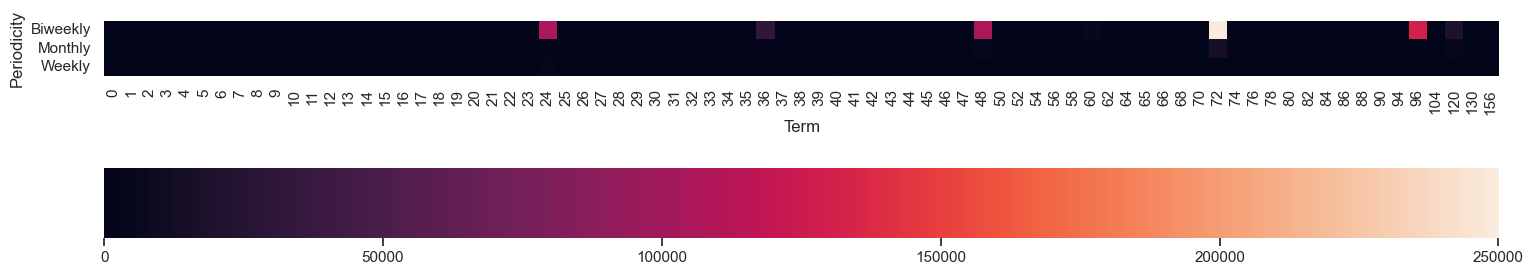

In [5]:
plt.figure(figsize=(18,8))
sns.heatmap(
    df_orig.pivot_table(index="Periodicity", columns="Term", values="LoanId", aggfunc="count", fill_value=0),
    square=True,
    cbar_kws={"orientation":"horizontal"},
)
plt.show()

## Payments
> Incluye pagos y dinámica histórica (desde 2019) de las operaciones de Hopp. La creación de créditos fue removida desde 2019 en adelante. Datos hasta junio 2020 inclusive.

```
LoanId (Entero): ID único del crédito.

PaymentId (Entero): ID único de cada pago.

PaymentSource (Categórica): Fuente de Pago (regular, contractor, alternative, additional).

PaymentType (Entero): Variable que clasifica distintos mecanismos de pago adicional.

PaymentTypeDescription (Categórica): Descripción de los mecanismos de pago adicional.

PaymentAmount (Decimal): Total pagado en el pago con PaymentId de la fila.

PaymentPrincipalAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de principal.

PaymentInterestAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de interés.

PaymentVATAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de IVA.

PaymentDueDate (Datetime): Fecha de aplicación del pago procesado (no disponible para todas las PaymentSources).

PaymentTransferDate (Datetime): Fecha en que Hopp recibió la transferencia bancaria del pago indicado (no disponible para todas las PaymentSources).

PaymentProcessingDate (Datetime): Fecha en que Hopp procesó el pago indicado (disponible para todas las PaymentSources).
```

In [6]:
df_payments = pd.read_csv("loan_payments_dataset.csv", parse_dates=["PaymentProcessingDate", "PaymentTransferDate", "PaymentDueDate"])

profile = ProfileReport(df_payments, title="Payments", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Difference between processing date and transfer date'}, xlabel='days', ylabel='count'>

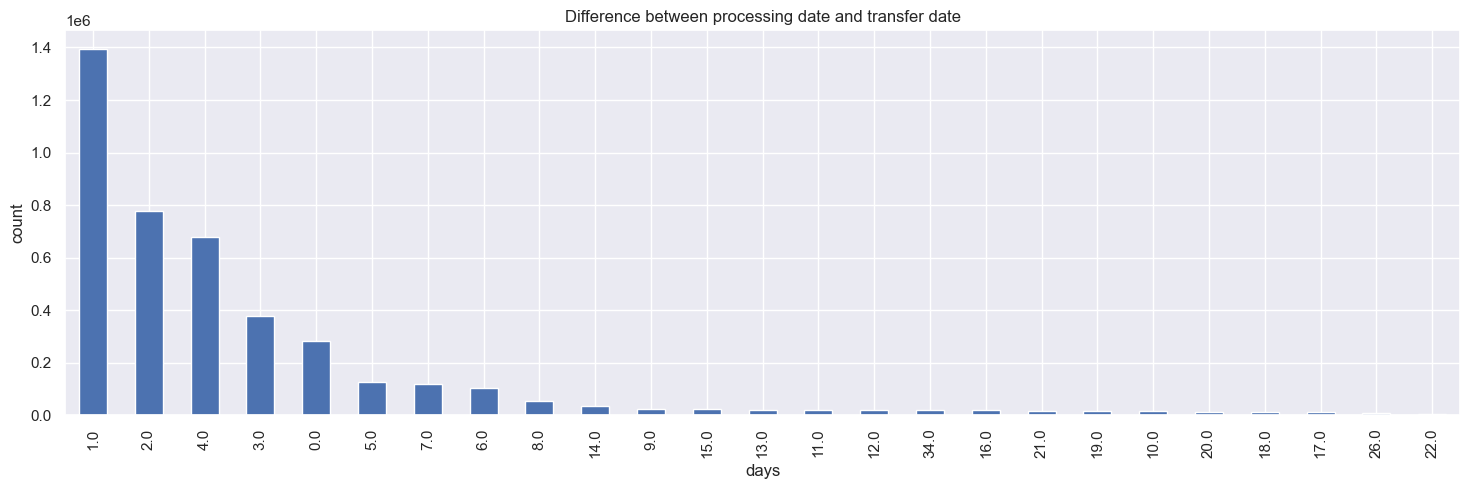

In [7]:
(df_payments.PaymentProcessingDate - df_payments.PaymentTransferDate).dt.days.value_counts().head(25).plot(
    kind="bar", title="Difference between processing date and transfer date",
    figsize=(18,5), xlabel="days", ylabel="count"
)

<AxesSubplot:title={'center':'Difference between payment due date and payment transfer date'}, xlabel='days', ylabel='count'>

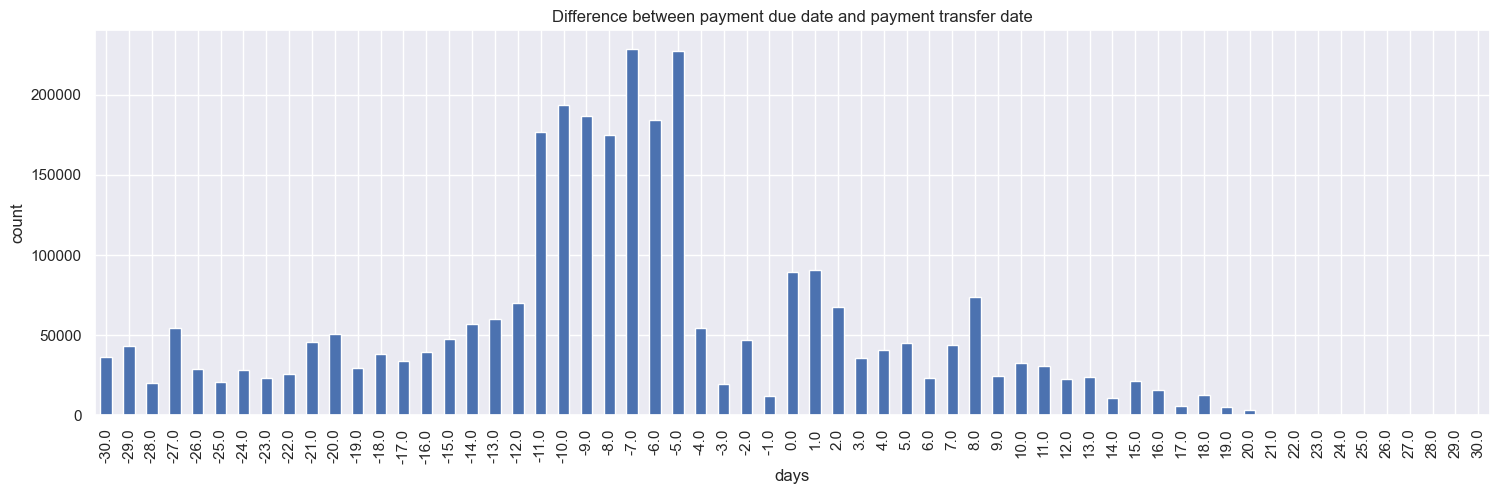

In [8]:
x = (df_payments[df_payments.PaymentDueDate.notna()].PaymentDueDate - df_payments[df_payments.PaymentDueDate.notna()].PaymentTransferDate).dt.days
x = x[x.between(-30, 30)].value_counts().sort_index()
x.plot(
    kind="bar", title="Difference between payment due date and payment transfer date", figsize=(18,5), xlabel="days", ylabel="count"
)

In [9]:
df_payments["DiffProcessingDateDueDate"] = (df_payments["PaymentProcessingDate"] - df_payments["PaymentDueDate"]).dt.days

In [ ]:
mean_diffdates = df_payments[df_payments.PaymentSource == "Regular"].sort_values("PaymentProcessingDate").groupby("LoanId").DiffProcessingDateDueDate.apply(np.diff).apply(np.mean)
sns.kdeplot(mean_diffdates)

In [ ]:
mean_diffdates[mean_diffdates.between(-1,1)]

In [ ]:
df_payments[df_payments.LoanId == 3600]

## Indexed dataset
> Información de tipo de indexación de cada crédito en el portafolio.

```
LoanId (Entero): ID único del crédito.

ProductName (Categórica): Tipo de producto (PDL, BGL).

Type (Categórica): Variable que indica si el crédito está indexado (Base, D-Indexed).

D-IndexedTo (Categórica): Variable que indica a quién indexa el crédito (Hopp, Zoltan, Ringu, Freeman).
```

In [ ]:
df_dindex = pd.read_csv("loan_dindexedto_dataset.csv")

profile = ProfileReport(df_dindex, title="Indexed to", minimal=True)
profile.to_widgets()

## Predictions sample
> Template con los préstamos y fechas a predecir.

In [ ]:
predictions_sample = pd.read_csv("loan_payments_dataset_scoring.csv", names=["PaymentCode", "PaymentPrincipal"], dtype={
    "PaymentCode": str,
    "PaymentPrincipal": float
})

predictions_sample = predictions_sample.join(predictions_sample.PaymentCode.astype(str).str.extract(r'^(?P<PaymentSource>\d{2})(?P<Date>\d{6})(?P<LoanId>.*)'))

predictions_sample.LoanId = predictions_sample.LoanId.astype(int)
predictions_sample.PaymentSource = predictions_sample.PaymentSource.astype(int)
# predictions_sample.PaymentTypeId = predictions_sample.PaymentTypeId.astype(int)

predictions_sample.Date = pd.to_datetime(predictions_sample.Date, format="%y%m%d").dt.date

predictions_sample["PaymentType"] = predictions_sample.PaymentSource.apply(lambda x: x if x not in (0,1,2) else None)

predictions_sample.PaymentSource = predictions_sample.PaymentSource.map({
    0: "Regular",
    1: "Alternative",
    2: "Contractor"
}).fillna("Alternative")

In [ ]:
predictions_sample.head()

In [ ]:
orig_loanids = set(df_orig.LoanId.unique())
predictions_loanids = set(predictions_sample.LoanId.unique())
print(f"All predictions in payments? {(orig_loanids & predictions_loanids) == predictions_loanids}. Diff: {len(predictions_loanids - orig_loanids)}")

In [ ]:
predictions_sample[~predictions_sample.LoanId.isin(df_orig.LoanId)]

In [ ]:
cheats = {
"002107235403":1474,
"002107205403":1474,
"002110225404":591,
"002110295405":488,
"002112285406":1247,
"002112305409":1253
}

In [ ]:
loan_ids_to_predict = predictions_sample.LoanId.unique()

In [ ]:
df_orig[df_orig.LoanId.isin(loan_ids_to_predict)].LoanOperationalStatus.value_counts().plot(kind="bar")

In [ ]:
predictions_sample.LoanId.value_counts()

# Cross reference payments and origin

In [ ]:
df = df_orig.merge(
    df_payments.LoanId.value_counts().rename("PaymentsRegistered"),
    left_on="LoanId",
    right_index=True
)
df["Progress"] = df.PaymentsRegistered / df.Term
sns.kdeplot(df[np.isfinite(df.Progress)].Progress)
plt.title("Payment progress")
plt.show()

# Do we need to predict for wanky loans?

In [ ]:
predictions_sample.LoanId.isin(
    df_orig[df_orig.Term == 0].LoanId
).nunique()

# Orient data

In [ ]:
df = pd.merge(df_payments, df_orig, left_on="LoanId", right_on="LoanId", how="left").sort_values(["PaymentProcessingDate", "LoanId", "PaymentId"])

In [ ]:
df = df.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

In [ ]:
df.head()

In [ ]:
nzpayments = df[df.PaymentPrincipal != 0][["LoanId", "PaymentPrincipal", "PaymentProcessingDate"]].rename(
    columns={"PaymentProcessingDate":"LastNonZeroPaymentProcessingDate", "PaymentPrincipal": "LastNonZeroPaymentPrincipal"}
)

In [ ]:
df = pd.merge_asof(df, nzpayments, left_on="PaymentProcessingDate", right_on="LastNonZeroPaymentProcessingDate", by="LoanId", direction="backward", allow_exact_matches=False)

In [ ]:
df["DaysSincePreviousNonZeroPayment"] = df.PaymentProcessingDate - df.LastNonZeroPaymentProcessingDate

In [ ]:
df["WasLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 30
df["WasReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 60
df["WasReallyReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 90
df["WasReallyReallyReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 180

In [ ]:
df["WasEverLate"] = df.groupby("LoanId").WasLate.cumsum() > 0
df["WasEverReallyLate"] = df.groupby("LoanId").WasReallyLate.cumsum() > 0
df["WasEverReallyReallyLate"] = df.groupby("LoanId").WasReallyReallyLate.cumsum() > 0
df["WasEverReallyReallyReallyLate"] = df.groupby("LoanId").WasReallyReallyReallyLate.cumsum() > 0

In [ ]:
df["InstallmentProportion"] = df.PaymentPrincipal / df.InstallmentAmount

In [ ]:
df = pd.merge_asof(df, df[["LoanId", "PaymentProcessingDate", "InstallmentProportion"]].rename(columns={"InstallmentProportion":"LastInstallmentProportion"}),
    left_on="PaymentProcessingDate", right_on="PaymentProcessingDate", by="LoanId", direction="backward", allow_exact_matches=False
)

In [ ]:
df["AccumulatedPrincipals"] = df.groupby("LoanId").PaymentPrincipal.cumsum()
df["PrincipalPaidOff"] = df.AccumulatedPrincipals >= df.LoanAmount

In [ ]:
df["PrincipalPaidOffProportion"] = df.AccumulatedPrincipals / df.LoanAmount

In [ ]:
df = df[(df.PaymentAmount >= 0) & (df.LoanAmount > 0)]

In [ ]:
categories = ["PaymentSource", "PaymentType", "AgencyId", "FundingID", "Periodicity", "LoanOperationalStatus", "VAT", "Term", "ProductName", "Type", "D-IndexedTo"]
for category in categories:
    df[category] = df[category].astype("category")

In [ ]:
# podria usar origination date

In [ ]:
train_columns = ['PaymentSource', 'PaymentType', 'PaymentTypeDescription', 'AgencyId', 'FundingID',
       'LoanAmount', 'Periodicity', 'VAT', 'Term',
       'InstallmentAmount', 'ProductName', 'Type', 'D-IndexedTo',
       'LastNonZeroPaymentPrincipal',
       'DaysSincePreviousNonZeroPayment', 'WasEverLate',
       'WasEverReallyLate', 'WasEverReallyReallyLate',
       'WasEverReallyReallyReallyLate',
       'LastInstallmentProportion', 'AccumulatedPrincipals', "PrincipalPaidOffProportion",
       'PrincipalPaidOff']

In [ ]:
# Voy a predecir InstallmentProportion y desde ahí calcular los de verdad

In [ ]:
from lightgbm import LGBMRegressor
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV

In [ ]:
df = df.sort_values(["LoanId", "PaymentProcessingDate"])
groups = LabelEncoder().fit_transform(df.LoanId)

In [ ]:
y = df.InstallmentProportion
X = df[train_columns]

In [ ]:
cv_args = {"test_size": 1, "train_size": 4}
cv = GroupTimeSeriesSplit(**cv_args)
# cv_splits = [_ for _ in cv.split(X, y, groups=groups)]
reg = DummyRegressor()
cross_val_score(reg, X, y, groups=groups, cv=cv).mean()